In [1]:
from vectorbtpro import *
import os
import talib

## Data Ingest

In [2]:
polygon_api_key = os.getenv('POLYGON_API_KEY')
vbt.PolygonData.set_custom_settings(
    client_config=dict(
        api_key=polygon_api_key
    )
)
data = vbt.PolygonData.pull(
    ["X:BTCUSD",
    "X:ETHUSD",
    "X:SOLUSD"],
    start="2022-01-01",
    timeframe="1 day"
)

data = data.rename_symbols({'X:BTCUSD':'BTCUSD', 
                            'X:ETHUSD' : 'ETHUSD', 
                            'X:SOLUSD' : 'SOLUSD'})

data.to_hdf('priceseries.h5')

 33%|###3      | 1/3 [00:02<00:04,  2.14s/it, symbol=X:ETHUSD]

In [2]:
data = vbt.HDFData.pull('priceseries.h5')

In [3]:
open = data.get('Open')
high = data.get('High')
low = data.get('Low')
close = data.get('Close')

In [4]:
data.data['BTCUSD'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1067 entries, 2022-01-01 00:00:00+00:00 to 2024-12-02 00:00:00+00:00
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1067 non-null   float64
 1   High         1067 non-null   float64
 2   Low          1067 non-null   float64
 3   Close        1067 non-null   float64
 4   Volume       1067 non-null   float64
 5   Trade count  1067 non-null   int64  
 6   VWAP         1067 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 66.7 KB


## Kaufmann Adaptive Moving Average (KAMA)

$$
\begin{align*}
\text{KAMA} &= \text{KAMA}_{i-1} + \text{sc}(\text{close} - \text{KAMA}_{i-1}) \\
\text{sc} &= ((\text{ER}_i \times (\text{fastest\_sc} - \text{slowest\_sc})) + \text{slowest\_sc})^2
\end{align*}
$$  

$$
\text{fastest\_sc} = \frac{2}{\text{fast MA period}+1}
$$
$$
\text{slowest\_sc} = \frac{2}{\text{slow MA period}+1}
$$
$$
\text{ER}_i = \frac{\lvert \text{close}_i - \text{close}_{i-n} \rvert}{\sum_{j=i-n}^i \lvert \text{close}_j - \text{close}_{j-1} \rvert}
$$
$$
n = \text{number of periods}
$$




In [5]:
@njit
def get_sc(close, period, fast_ma_len, slow_ma_len):
    fastest_sc = 2 / (fast_ma_len + 1)
    slowest_sc = 2 / (slow_ma_len + 1)

    price_shifted_1 = np.roll(close,1)
    price_shifted_1[0] = np.nan
    diff_close = np.abs(close - price_shifted_1)

    conv_arr = np.ones(period,dtype=np.float64)
    denominator = np.convolve(diff_close, conv_arr, 'full')[:-(period-1)] 

    price_shifted_period = np.roll(close,period)
    price_shifted_period[0:period] = np.nan
    
    ER = np.abs(close - price_shifted_period) / denominator
    sc = (ER * (fastest_sc - slowest_sc) + slowest_sc) ** 2
    return sc

@njit
def get_kama(close, period, fast_ma_len, slow_ma_len):
    sc = get_sc(close, period, fast_ma_len, slow_ma_len)
    kama = np.full((close.shape[0]), np.nan)
    for i in range(1,close.shape[0]):  
        if not np.isnan(sc[i]):
            if np.isnan(kama[i-1]):
                kama[i-1] = close[0]
            kama[i] = kama[i-1] + (sc[i] * (close[i] - kama[i-1]))
        else:
            kama[i] = np.nan
    return kama

@njit
def get_kama_pairs(close, period, kama_st_ma_len, kama_lt_ma_len, fast_ma_len=2, slow_ma_len=30):
    kama = get_kama(close, period, fast_ma_len, slow_ma_len)
    
    st_conv_arr = np.ones(kama_st_ma_len, dtype=np.float64)
    st_conv = np.convolve(kama, st_conv_arr, 'full')[:-(kama_st_ma_len-1)] 
    kama_st_ma = st_conv / kama_st_ma_len
    
    lt_conv_arr = np.ones(kama_lt_ma_len, dtype=np.float64)
    lt_conv = np.convolve(kama, lt_conv_arr, 'full')[:-(kama_lt_ma_len-1)] 
    kama_lt_ma = lt_conv / kama_lt_ma_len

    return kama_st_ma, kama_lt_ma

In [6]:
Kama = vbt.IF(
    class_name = 'Kaufmann Adaptive Moving Average',
    short_name = 'KAMA',
    input_names = ['close'], 
    param_names = ['period', 'fast_ma_len', 'slow_ma_len', 'kama_st_ma_len', 'kama_lt_ma_len'],
    output_names = ['kama_st_ma', 'kama_lt_ma']
).with_apply_func(
    get_kama_pairs,
    takes_1d=True,
    period=10,
    fast_ma_len=2,
    slow_ma_len=30,
    kama_st_ma_len=12,
    kama_lt_ma_len=26
)

In [7]:
vbt.phelp(Kama.run)

Kaufmann Adaptive Moving Average.run(
    close,
    period=Default(value=10),
    fast_ma_len=Default(value=2),
    slow_ma_len=Default(value=30),
    kama_st_ma_len=Default(value=12),
    kama_lt_ma_len=Default(value=26),
    short_name='KAMA',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `Kaufmann Adaptive Moving Average` indicator.
    
    * Inputs: `close`
    * Parameters: `period`, `fast_ma_len`, `slow_ma_len`, `kama_st_ma_len`, `kama_lt_ma_len`
    * Outputs: `kama_st_ma`, `kama_lt_ma`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `Kaufmann Adaptive Moving Average.run_pipeline`.


In [8]:
class Kama(Kama):
    def plot(self,
             column=None,
             close_kwargs=None,
             kama_st_kwargs=None,
             kama_lt_kwargs=None,
             fig=None,
             **layout_kwargs
            ):
        close_kwargs = close_kwargs if close_kwargs else {}
        kama_st_kwargs = kama_st_kwargs if kama_st_kwargs else {}
        kama_lt_kwargs = kama_lt_kwargs if kama_lt_kwargs else {}

        close = self.select_col_from_obj(self.close, column).rename('Close')
        kama_st = self.select_col_from_obj(self.kama_st_ma, column).rename('ST Kama')
        kama_lt = self.select_col_from_obj(self.kama_lt_ma, column).rename('LT Kama')

        fig = close.vbt.plot(fig=fig, **close_kwargs, **layout_kwargs)
        kama_st.vbt.plot(fig=fig, **kama_st_kwargs)
        kama_lt.vbt.plot(fig=fig, **kama_lt_kwargs)

        return fig
        

In [9]:
kama = Kama.run(close)

In [9]:
kama.plot(column='BTCUSD',
          close_kwargs=dict(trace_kwargs=dict(line_color='blue')),
          kama_st_kwargs=dict(trace_kwargs=dict(line_color='limegreen')),
          kama_lt_kwargs=dict(trace_kwargs=dict(line_color='orange'))).show()

NameError: name 'kama' is not defined

## Signal Generation

In [10]:
@njit
def generate_signals(kama_st, kama_lt):
    entries = vbt.nb.crossed_above_nb(kama_st, kama_lt)
    exits = vbt.nb.crossed_below_nb(kama_st, kama_lt) 

    return (entries,exits)

In [12]:
signals = generate_signals(kama.kama_st_ma.to_numpy(), kama.kama_lt_ma.to_numpy())

## Pre-Analysis

In [13]:
def validate_signals(data, symbol, raw_signals, filtered_signals=None): 
    fig = data.plot(
        symbol=symbol, 
        ohlc_trace_kwargs=dict(opacity=0.5), 
        plot_volume=False
    )

    entries_raw = pd.DataFrame(raw_signals[0], columns=data.columns, index=data.index)
    exits_raw = pd.DataFrame(raw_signals[1], columns=data.columns, index=data.index)
    
    entries_raw[symbol].vbt.signals.plot_as_entries(y=data.get("Close", symbol), fig=fig)
    exits_raw[symbol].vbt.signals.plot_as_exits(y=data.get("Close", symbol), fig=fig)
    
    if(filtered_signals != None):
        entries_filtered = filtered_signals[0]
        exits_filtered = filtered_signals[1]
        
        entries_filtered[symbol].vbt.signals.plot_as_entry_marks(y=data.get("Close", symbol), fig=fig, trace_kwargs=dict(name="New entries"))
        exits_filtered[symbol].vbt.signals.plot_as_exit_marks(y=data.get("Close", symbol), fig=fig, trace_kwargs=dict(name="New exits"))

    fig.update_layout(height=600, width=1100)
    return fig

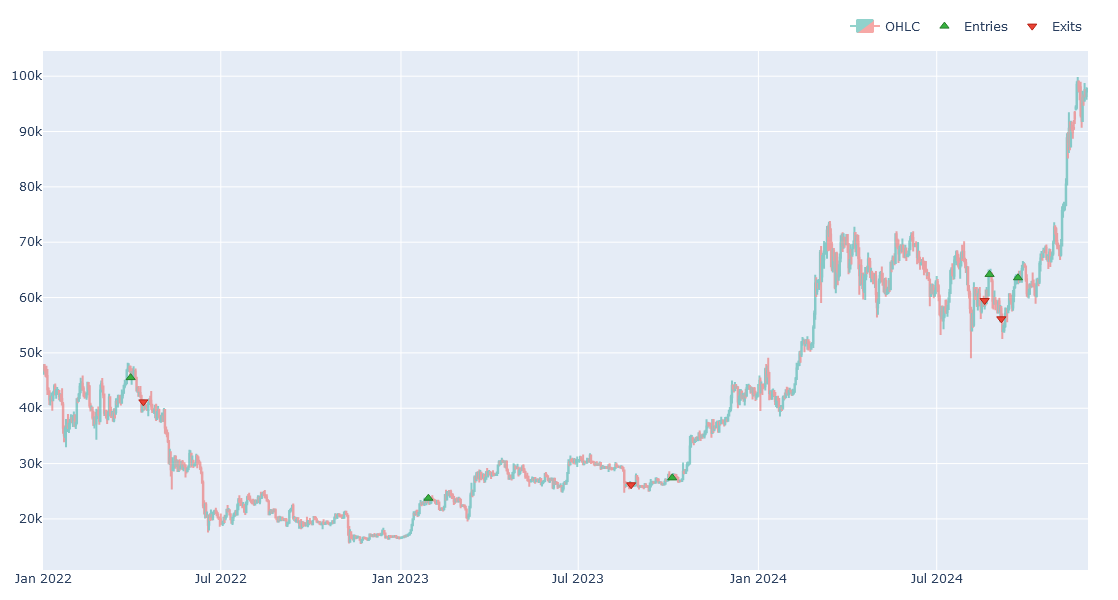

In [14]:
fig = validate_signals(data, 'BTCUSD', signals)
fig.show()

## Backtesting

In [15]:
pf = vbt.Portfolio.from_signals(
    close=close, 
    entries=signals[0], 
    exits=signals[1]
)

In [16]:
pf['SOLUSD'].stats()

Start Index                   2022-01-01 00:00:00+00:00
End Index                     2024-12-02 00:00:00+00:00
Total Duration                       1067 days 00:00:00
Start Value                                       100.0
Min Value                                     68.165626
Max Value                                    676.073493
End Value                                    621.615449
Total Return [%]                             521.615449
Benchmark Return [%]                          31.973662
Position Coverage [%]                         41.237113
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              44.537813
Max Drawdown Duration                 235 days 00:00:00
Total Orders                                          5
Total Fees Paid                                     0.0
Total Trades                                          3
Win Rate [%]                                       50.0
Best Trade [%]                               456

## Optimization

Parameter Space created by taking the Catesian Product to cover all input parameter combinations

$$
A \times B = \{(a,b) \vert a\in A \land b\in B \}
$$

In [17]:
kama_lt_ma_len=np.arange(15,35)
kama_st_ma_len=np.arange(5,15)
period = np.arange(2,35)

In [18]:
kama = Kama.run(
    close,
    period=period,
    kama_lt_ma_len=kama_lt_ma_len,
    kama_st_ma_len=kama_st_ma_len,
    param_product=True
)

 37%|###6      | 7233/19800 [00:02<00:03, 3616.25it/s, KAMA_period=14, KAMA_kama_st_ma_len=5, KAMA_kama_lt_ma_…

In [19]:
kama.wrapper.columns

MultiIndex([( 2,  5, 15, 'BTCUSD'),
            ( 2,  5, 15, 'ETHUSD'),
            ( 2,  5, 15, 'SOLUSD'),
            ( 2,  5, 16, 'BTCUSD'),
            ( 2,  5, 16, 'ETHUSD'),
            ( 2,  5, 16, 'SOLUSD'),
            ( 2,  5, 17, 'BTCUSD'),
            ( 2,  5, 17, 'ETHUSD'),
            ( 2,  5, 17, 'SOLUSD'),
            ( 2,  5, 18, 'BTCUSD'),
            ...
            (34, 14, 31, 'SOLUSD'),
            (34, 14, 32, 'BTCUSD'),
            (34, 14, 32, 'ETHUSD'),
            (34, 14, 32, 'SOLUSD'),
            (34, 14, 33, 'BTCUSD'),
            (34, 14, 33, 'ETHUSD'),
            (34, 14, 33, 'SOLUSD'),
            (34, 14, 34, 'BTCUSD'),
            (34, 14, 34, 'ETHUSD'),
            (34, 14, 34, 'SOLUSD')],
           names=['KAMA_period', 'KAMA_kama_st_ma_len', 'KAMA_kama_lt_ma_len', 'symbol'], length=19800)

In [20]:
kama.getsize()

'339.2 MB'

## Pipeline

In [21]:
def pipeline(data, period=10, kama_st_ma_len=12, kama_lt_ma_len=26):
    close = data.get('Close')
    
    kama = Kama.run(
        close,
        period=period,
        kama_lt_ma_len=kama_lt_ma_len,
        kama_st_ma_len=kama_st_ma_len,
        param_product=True
    )

    raw_signals, filtered_signals = generate_signals(kama)
    
    pf = vbt.Portfolio.from_signals(
        close,
        entries=filtered_signals[0],
        exits=filtered_signals[1],
        fees=0.001,
        save_returns=True,  
        max_order_records=0,
        freq='1d'
    )
    return pf.sharpe_ratio
    

In [22]:
pipeline(data,10,12,26)

TypeError: not enough arguments: expected 2, got 1

In [23]:
chunked_pipeline = vbt.chunked(
    size=vbt.LenSizer(arg_query='period', single_type=int),  
    arg_take_spec=dict(  
        data=None,  
        period=vbt.ChunkSlicer(),  
        kama_st_ma_len=vbt.ChunkSlicer(),
        kama_lt_ma_len=vbt.ChunkSlicer()
    ),
    merge_func=lambda x: pd.concat(x).sort_index()  
)(pipeline)

In [11]:
op_tree = (product, period, kama_st_ma_len, kama_lt_ma_len)
param_products = vbt.generate_param_combs(op_tree) 
period_prod = np.asarray(param_products[0])
kama_st_ma_len_prod = np.asarray(param_products[1])
kama_lt_ma_len_prod = np.asarray(param_products[2])

NameError: name 'period' is not defined

In [280]:
kama_st_ma, kama_lt_ma = get_kama_pairs(close.values[:, 0], 10, 12, 26)

In [71]:
@njit(nogil=True)
def pipeline_nb(close, 
                kama_periods=np.asarray([10,11]), 
                kama_lt_ma_len=np.asarray([12,13]), 
                kama_st_ma_len=np.asarray([26,27])):

    sharpe = np.empty(kama_periods.size * close.shape[1], dtype=np.float_)
    long_entries = np.empty(close.shape, dtype=np.bool_)
    long_exits = np.empty(close.shape, dtype=np.bool_)
    group_lens = np.full(close.shape[1], 1)
    k = 0

    for i in range(kama_periods.size):
        for col in range(close.shape[1]): # for each asset
 
            kama_st_ma, kama_lt_ma = get_kama_pairs(close[:, col], 
                                              kama_periods[i], 
                                              kama_st_ma_len[i], 
                                              kama_lt_ma_len[i])
            
            long_entries[:, col] = vbt.nb.crossed_above_1d_nb(kama_st_ma, kama_lt_ma)
            long_exits[:, col] = vbt.nb.crossed_below_1d_nb(kama_st_ma, kama_lt_ma)

            sim_out = vbt.pf_nb.from_signals_nb(
                target_shape=close.shape,
                group_lens=group_lens,
                close=close,
                long_entries=long_entries,
                long_exits=long_exits,
                save_returns=True
            )
            returns = sim_out.in_outputs.returns
            _sharpe = vbt.ret_nb.sharpe_ratio_nb(returns, 365, ddof=1)
            sharpe = np.append(sharpe, _sharpe)
            #k += close.shape[1]
            
    return sharpe


In [72]:
pipeline_nb(data.get('Close').values)

array([ 9.92168240e+247,  3.76062857e+199,  5.13153820e-038,
        1.13010740e+098,  1.37020833e-066,  2.56108366e+242,
        3.20337716e-001, -1.40332865e-002,  2.71420242e-001,
        3.20337716e-001,  4.08521698e-002,  2.71420242e-001,
        3.20337716e-001,  4.08521698e-002,  2.60940279e-001,
        5.05173052e-001,  4.08521698e-002,  2.60940279e-001,
        5.05173052e-001,  2.38931027e-002,  2.60940279e-001,
        5.05173052e-001,  2.38931027e-002,  1.24934425e-002])

In [19]:
close = close.values
kama_periods=np.asarray([10])
kama_lt_ma_len=np.asarray([12])
kama_st_ma_len=np.asarray([26])

In [20]:
sharpe = np.empty(kama_periods.size * close.shape[1], dtype=np.float_)
long_entries = np.empty(close.shape, dtype=np.bool_)
long_exits = np.empty(close.shape, dtype=np.bool_)
group_lens = np.full(close.shape[1], 1)
k = 0
i=0
col=0


In [21]:
kama_st_ma, kama_lt_ma = get_kama_pairs(close[:, col], 
                                              kama_periods[i], 
                                              kama_st_ma_len[i], 
                                              kama_lt_ma_len[i])
            
long_entries[:, col] = vbt.nb.crossed_above_1d_nb(kama_st_ma, kama_lt_ma)
long_exits[:, col] = vbt.nb.crossed_below_1d_nb(kama_st_ma, kama_lt_ma)

In [22]:
sim_out = vbt.pf_nb.from_signals_nb(
    target_shape=close.shape,
    group_lens=group_lens,
    close=close,
    long_entries=long_entries,
    long_exits=long_exits,
    save_returns=True
)

In [25]:
returns = sim_out.in_outputs.returns
_sharpe = vbt.ret_nb.sharpe_ratio_nb(returns, 365, ddof=1)
_sharpe

array([0.32033772, 0.10797783, 0.61188331])

In [26]:
sharpe[0:3] = _sharpe

In [27]:
sharpe[k:k + close.shape[1]] = _sharpe
k += close.shape[1]

In [28]:
sharpe

array([0.32033772, 0.10797783, 0.61188331])